<a href="https://colab.research.google.com/github/prathyusha-pateel/ab-testing/blob/main/mobile_games_ab_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Game Retention A/B Testing (Cookie Cats Dataset)

Cookie Cats is a popular mobile puzzle game where players solve puzzles to help a cat collect cookies. The game includes "gates" that require players to wait or make in-app purchases to progress.

**The Question:** Does moving the first gate from level 30 to level 40 increase player retention and engagement?

**Test Groups:**

* Control Group: Gate at level 30
* Treatment Group: Gate at level 40

**Key Metrics:**

* Day 1 Retention: Whether players return 1 day after installation
* Day 7 Retention: Whether players return 7 days after installation
* Game Rounds: Number of game rounds played within 14 days

## Setup and Dependencies

First, let's import the required libraries:

In [1]:
# Data manipulation and analysis
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical testing
from scipy.stats import chi2_contingency, mannwhitneyu

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

## Data Loading

Let's load the Cookie Cats dataset:

In [2]:
# URL of the CSV file on GitHub
url = "https://raw.githubusercontent.com/prathyusha-pateel/ab-testing/refs/heads/main/cookie_cats.csv"

# Load the dataset directly from the URL
df = pd.read_csv(url)

# Display the first few rows
df.head()


,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
# Check dataset information
print(f"Dataset shape: {df.shape}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nMissing values:\n{df.isnull().sum()}")

Dataset shape: (90189, 5)

Data types:
userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object

Missing values:
userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64


## Exploratory Data Analysis

Let's explore the dataset to understand its structure and characteristics:

Version counts:
version
gate_40    45489
gate_30    44700
Name: count, dtype: int64
Version percentages:
version
gate_40    50.437415
gate_30    49.562585
Name: count, dtype: float64%



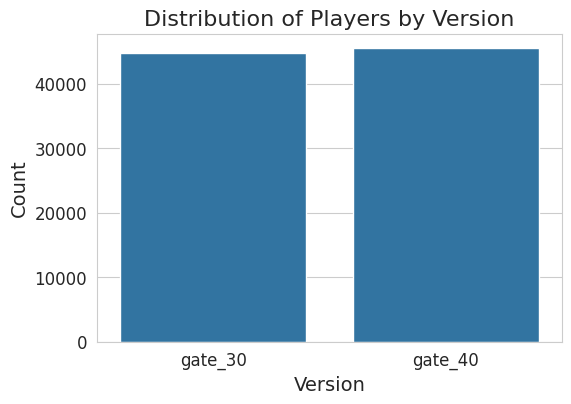

In [4]:
# Check distribution of versions (control vs. treatment)
version_counts = df['version'].value_counts()
print(f"Version counts:\n{version_counts}")
print(f"Version percentages:\n{version_counts / len(df) * 100}%\n")

# Visualize the distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='version', data=df)
plt.title('Distribution of Players by Version', fontsize=16)
plt.xlabel('Version', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

In [5]:
# Check basic statistics for game rounds
print("Game Rounds Statistics:")
print(df.groupby('version')['sum_gamerounds'].describe())

Game Rounds Statistics:
           count       mean         std  min  25%   50%   75%      max
version                                                               
gate_30  44700.0  52.456264  256.716423  0.0  5.0  17.0  50.0  49854.0
gate_40  45489.0  51.298776  103.294416  0.0  5.0  16.0  52.0   2640.0


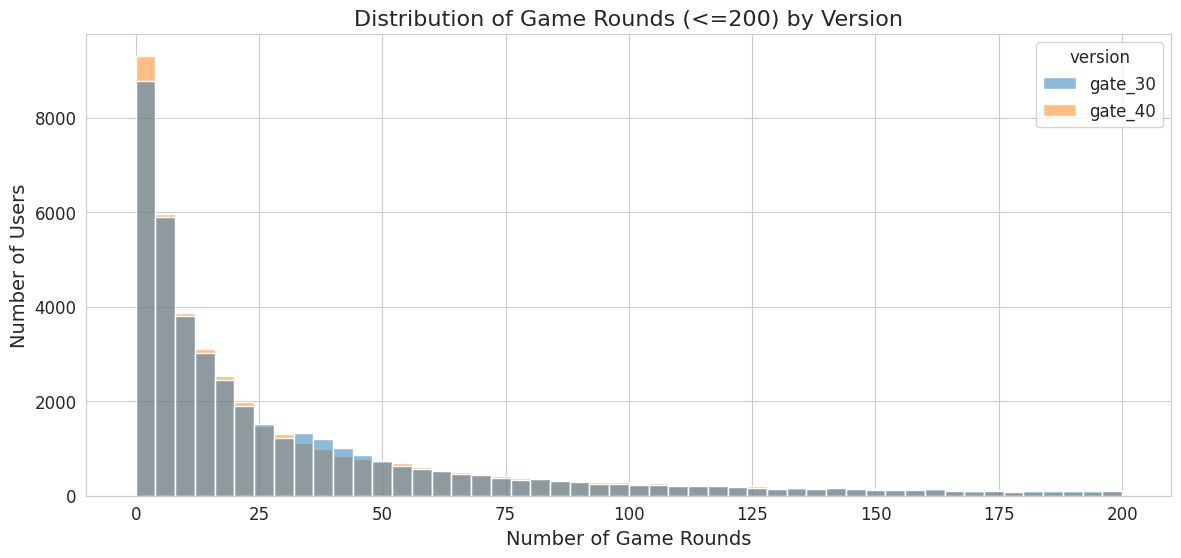

In [6]:
plt.figure(figsize=(14, 6))

# Filter to focus on typical range
df_trimmed = df[df['sum_gamerounds'] <= 200]

# Plot and capture the returned axis object
plot = sns.histplot(
    data=df_trimmed,
    x='sum_gamerounds',
    hue='version',
    bins=50,
    multiple='layer',
    stat='count',
    common_norm=False
)

plt.title('Distribution of Game Rounds (<=200) by Version', fontsize=16)
plt.xlabel('Number of Game Rounds', fontsize=14)
plt.ylabel('Number of Users', fontsize=14)

# Force legend to appear
handles, labels = plot.get_legend_handles_labels()
if handles and labels:
    plt.legend(handles=handles, labels=labels, title='Version')

plt.show()


### Retention Analysis

Now, let's analyze the retention rates for both Day 1 and Day 7:

In [7]:
# Calculate retention rates by version
retention_1_by_version = df.groupby('version')['retention_1'].mean()
retention_7_by_version = df.groupby('version')['retention_7'].mean()

print(f"Day 1 Retention Rates:\n{retention_1_by_version}\n")
print(f"Day 7 Retention Rates:\n{retention_7_by_version}\n")

# Calculate relative differences
rel_diff_1 = (retention_1_by_version['gate_30'] - retention_1_by_version['gate_40']) / retention_1_by_version['gate_40'] * 100
rel_diff_7 = (retention_7_by_version['gate_30'] - retention_7_by_version['gate_40']) / retention_7_by_version['gate_40'] * 100

print(f"Relative difference in Day 1 Retention: {rel_diff_1:.2f}%")
print(f"Relative difference in Day 7 Retention: {rel_diff_7:.2f}%")

Day 1 Retention Rates:
version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

Day 7 Retention Rates:
version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

Relative difference in Day 1 Retention: 1.34%
Relative difference in Day 7 Retention: 4.51%


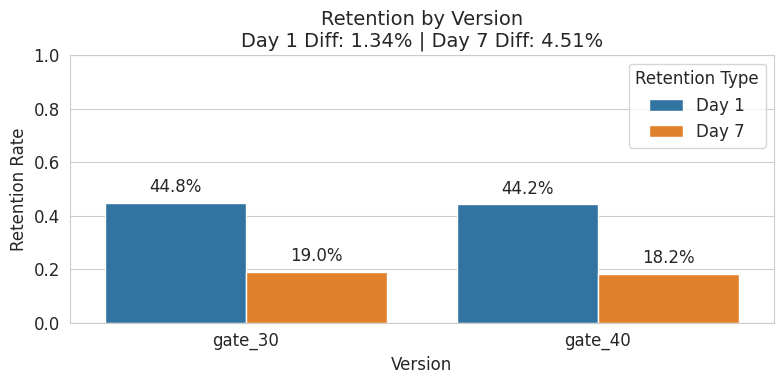

In [21]:
# Create a DataFrame from the calculated retention rates
retention_data = pd.DataFrame({
    'Day 1': retention_1_by_version,
    'Day 7': retention_7_by_version
}).reset_index()

# Melt the DataFrame for seaborn
retention_melted = pd.melt(
    retention_data,
    id_vars='version',
    var_name='Retention Type',
    value_name='Retention Rate'
)

# Plot
plt.figure(figsize=(8, 4))
chart = sns.barplot(
    data=retention_melted,
    x='version',
    y='Retention Rate',
    hue='Retention Type'
)

# Add labels
for p in chart.patches:
    height = p.get_height()
    if height and height > 0.001:  # Add small threshold to avoid floating-point false positives
        chart.annotate(
            f'{height:.1%}',
            (p.get_x() + p.get_width() / 2., height),
            ha='center',
            va='bottom',
            xytext=(0, 5),
            textcoords='offset points'
        )

# Title with relative differences
plt.title(
    f"Retention by Version\n"
    f"Day 1 Diff: {rel_diff_1:.2f}% | Day 7 Diff: {rel_diff_7:.2f}%",
    fontsize=14
)
plt.xlabel('Version', fontsize=12)
plt.ylabel('Retention Rate', fontsize=12)
plt.legend(title='Retention Type')
plt.ylim(0, 1)  # Set max to 100% for clarity
plt.tight_layout()
plt.show()

## Statistical Testing

Now, let's perform statistical tests to determine if the observed differences are statistically significant:

### Chi-Square Test

The Chi-Square test was used for retention rate comparisons because:



*   It's appropriate for comparing proportions (retention rates) between two groups
*   It doesn't assume normal distribution
*  It's suitable for categorical outcomes (retained vs. not retained)




In [9]:

# Create contingency table for Day 1 Retention
contingency_1 = pd.crosstab(df['version'], df['retention_1'])
print("Contingency Table for Day 1 Retention:")
print(contingency_1)


chi2_1, p_1, dof_1, expected_1 = chi2_contingency(contingency_1)
print(f"\nChi-Square Test Results for Day 1 Retention:")
print(f"Chi-Square value: {chi2_1:.4f}")
print(f"p-value: {p_1:.4f}")
print(f"Statistically significant: {p_1 < 0.05}")

Contingency Table for Day 1 Retention:
retention_1  False  True 
version                  
gate_30      24666  20034
gate_40      25370  20119

Chi-Square Test Results for Day 1 Retention:
Chi-Square value: 3.1591
p-value: 0.0755
Statistically significant: False


In [10]:

# Create contingency table for Day 7 Retention
contingency_7 = pd.crosstab(df['version'], df['retention_7'])
print("Contingency Table for Day 7 Retention:")
print(contingency_7)


chi2_7, p_7, dof_7, expected_7 = chi2_contingency(contingency_7)
print(f"\nChi-Square Test Results for Day 7 Retention:")
print(f"Chi-Square value: {chi2_7:.4f}")
print(f"p-value: {p_7:.4f}")
print(f"Statistically significant: {p_7 < 0.05}")

Contingency Table for Day 7 Retention:
retention_7  False  True 
version                  
gate_30      36198   8502
gate_40      37210   8279

Chi-Square Test Results for Day 7 Retention:
Chi-Square value: 9.9591
p-value: 0.0016
Statistically significant: True


### Mann-Whitney U Test

The Mann-Whitney U test was used for game rounds comparison because:

* It's a non-parametric test that doesn't assume normal distribution
* The distribution of game rounds is highly skewed
* It compares the distribution of values rather than just means

In [11]:

# Extract game rounds by version
gate_30_rounds = df[df['version'] == 'gate_30']['sum_gamerounds']
gate_40_rounds = df[df['version'] == 'gate_40']['sum_gamerounds']


u_stat, p_rounds = mannwhitneyu(gate_30_rounds, gate_40_rounds)
print(f"Mann-Whitney U Test Results for Game Rounds:")
print(f"U statistic: {u_stat}")
print(f"p-value: {p_rounds:.4f}")
print(f"Statistically significant: {p_rounds < 0.05}")

Mann-Whitney U Test Results for Game Rounds:
U statistic: 1024331250.5
p-value: 0.0502
Statistically significant: False


## Relationship Between Game Rounds and Retention

Let's analyze if there's a relationship between the number of game rounds played and retention rates:

In [12]:
# Create game round buckets for better analysis
def create_round_buckets(game_rounds):
    if game_rounds == 0:
        return '0'
    elif game_rounds <= 5:
        return '1-5'
    elif game_rounds <= 10:
        return '6-10'
    elif game_rounds <= 25:
        return '11-25'
    elif game_rounds <= 50:
        return '26-50'
    elif game_rounds <= 100:
        return '51-100'
    else:
        return '100+'

df['round_bucket'] = df['sum_gamerounds'].apply(create_round_buckets)

In [13]:
# Calculate retention rates by round bucket and version
retention_by_rounds = df.groupby(['version', 'round_bucket']).agg({
    'retention_1': 'mean',
    'retention_7': 'mean',
    'userid': 'count'
}).reset_index()

retention_by_rounds = retention_by_rounds.rename(columns={'userid': 'count'})
retention_by_rounds

,version,round_bucket,retention_1,retention_7,count
0,gate_30,0,0.021167,0.008260,1937
1,gate_30,1-5,0.073130,0.012946,10119
2,gate_30,100+,0.902051,0.713864,6095
3,gate_30,11-25,0.428873,0.077452,9012
4,gate_30,26-50,0.664486,0.176334,6879
5,gate_30,51-100,0.812339,0.380877,5041
6,gate_30,6-10,0.217910,0.030799,5617
7,gate_40,0,0.022363,0.006320,2057
8,gate_40,1-5,0.081007,0.014429,10604
9,gate_40,100+,0.897774,0.712401,6290


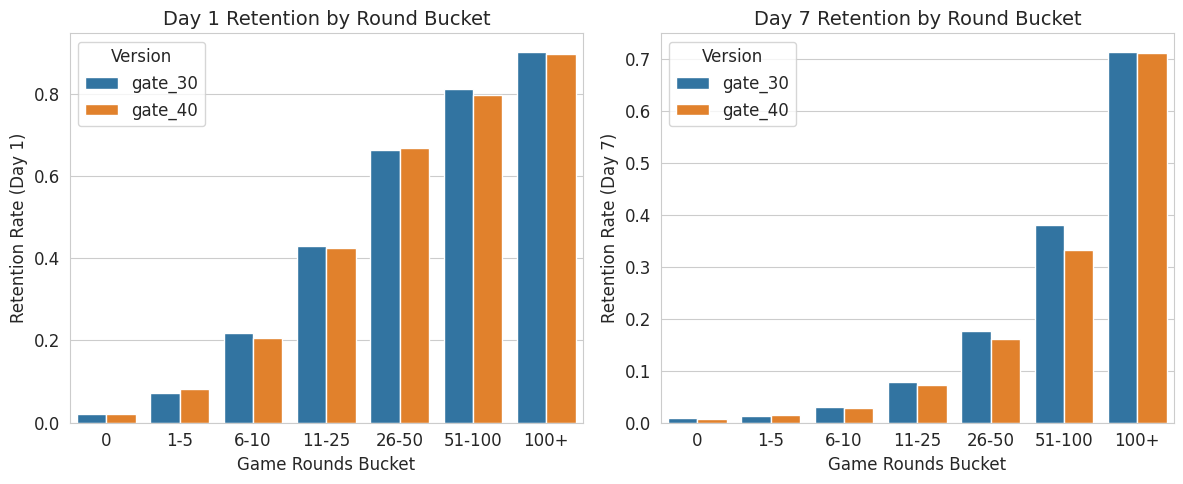

In [20]:
plt.figure(figsize=(12, 5))

# Sort round_bucket logically
round_order = ['0', '1-5', '6-10', '11-25', '26-50', '51-100', '100+']

# Plot for Retention Day 1
plt.subplot(1, 2, 1)
sns.barplot(
    data=retention_by_rounds,
    x='round_bucket',
    y='retention_1',
    hue='version',
    order=round_order
)
plt.title('Day 1 Retention by Round Bucket', fontsize=14)
plt.xlabel('Game Rounds Bucket')
plt.ylabel('Retention Rate (Day 1)')
plt.legend(title='Version')

# Plot for Retention Day 7
plt.subplot(1, 2, 2)
sns.barplot(
    data=retention_by_rounds,
    x='round_bucket',
    y='retention_7',
    hue='version',
    order=round_order
)
plt.title('Day 7 Retention by Round Bucket', fontsize=14)
plt.xlabel('Game Rounds Bucket')
plt.ylabel('Retention Rate (Day 7)')
plt.legend(title='Version')

plt.tight_layout()
plt.show()

## Conclusions and Recommendations

Based on our statistical analysis, we can draw the following conclusions:

In [15]:
# Create a summary of key findings
results = {
    "Day 1 Retention": {
        "Gate 30": f"{retention_1_by_version['gate_30']:.1%}",
        "Gate 40": f"{retention_1_by_version['gate_40']:.1%}",
        "Relative Difference": f"{rel_diff_1:.1f}%",
        "p-value": f"{p_1:.4f}",
        "Significant": "Yes" if p_1 < 0.05 else "No"
    },
    "Day 7 Retention": {
        "Gate 30": f"{retention_7_by_version['gate_30']:.1%}",
        "Gate 40": f"{retention_7_by_version['gate_40']:.1%}",
        "Relative Difference": f"{rel_diff_7:.1f}%",
        "p-value": f"{p_7:.4f}",
        "Significant": "Yes" if p_7 < 0.05 else "No"
    },
    "Game Rounds": {
        "Gate 30 Median": f"{gate_30_rounds.median()}",
        "Gate 40 Median": f"{gate_40_rounds.median()}",
        "Relative Difference": f"{(gate_30_rounds.median() - gate_40_rounds.median()) / gate_40_rounds.median() * 100:.1f}%",
        "p-value": f"{p_rounds:.4f}",
        "Significant": "Yes" if p_rounds < 0.05 else "No"
    }
}

# Display the results
for metric, values in results.items():
    print(f"\n{metric}:")
    for key, value in values.items():
        print(f"  {key}: {value}")


Day 1 Retention:
  Gate 30: 44.8%
  Gate 40: 44.2%
  Relative Difference: 1.3%
  p-value: 0.0755
  Significant: No

Day 7 Retention:
  Gate 30: 19.0%
  Gate 40: 18.2%
  Relative Difference: 4.5%
  p-value: 0.0016
  Significant: Yes

Game Rounds:
  Gate 30 Median: 17.0
  Gate 40 Median: 16.0
  Relative Difference: 6.2%
  p-value: 0.0502
  Significant: No


### Key Findings

1. **Day 1 Retention**: The difference in Day 1 retention between Gate 30 (44.8%) and Gate 40 (44.2%) is 1.3%, which is not statistically significant (p = 0.0755). However, it's very close to the significance threshold and shows a positive trend favoring Gate 30.

2. **Day 7 Retention**: The difference in Day 7 retention between Gate 30 (19.0%) and Gate 40 (18.2%) is 4.5%, which is statistically significant (p = 0.0016). This provides strong evidence that Gate 30 placement leads to better long-term retention.

3. **Game Rounds**: Players with Gate 30 play a median of 17 rounds, while those with Gate 40 play a median of 16 rounds. This 6.2% difference is nearly statistically significant (p = 0.0502), again favoring Gate 30.

4. **Retention by Game Rounds**: There's a clear positive relationship between the number of game rounds played and retention rates, for both Day 1 and Day 7 retention. This suggests that engaging players early (during their first sessions) is crucial for long-term retention.

### Business Recommendation

Based on the statistically significant improvement in 7-day retention with Gate 30, we recommend keeping the gate at level 30 rather than moving it to level 40. The combined evidence from all metrics consistently favors the Gate 30 placement, with the Day 7 retention improvement being particularly important as it's a strong indicator of long-term player value.

Why might Gate 30 perform better?
- Players may find level 30 a more natural stopping point than level 40
- The earlier gate may create a more balanced gaming experience
- The 30-level gate may better align with the game's difficulty curve

This analysis demonstrates the importance of data-driven decision making in game design, as small changes in game mechanics can have significant impacts on player retention and engagement.